# SETUP AND IMPORTS


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Plotting configuration
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("All imports successful")
print("Ready to analyze LP Score v4 dataset")

All imports successful
Ready to analyze LP Score v4 dataset


DATA LOADING AND INITIAL EXPLORATION

In [12]:
def load_and_explore_data(file_path):
    """
    Load the LP scoring dataset and perform initial exploration
    """
    print("Loading dataset...")

    # Load data
    df = pd.read_csv(file_path)

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()[:10]}..." if len(df.columns) > 10 else f"📋 Columns: {df.columns.tolist()}")

    # Basic info
    print("\n BASIC DATASET INFO:")
    print(f"• Rows: {len(df):,}")
    print(f"• Columns: {len(df.columns):,}")
    print(f"• Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"• Duplicate rows: {duplicates}")

    # Missing values overview
    missing_cols = df.isnull().sum()
    missing_cols = missing_cols[missing_cols > 0].sort_values(ascending=False)
    if len(missing_cols) > 0:
        print(f"\n  MISSING VALUES:")
        for col, count in missing_cols.head(10).items():
            print(f"• {col}: {count:,} ({count/len(df)*100:.1f}%)")
    else:
        print("\n No missing values found")

    return df

def analyze_key_fields(df):
    """
    Analyze the key fields mentioned in the problem statement
    """
    print("\n KEY FIELDS ANALYSIS:")

    # Top-level fields
    key_fields = ['_id', 'wallet_id', 'aggregated_lp_score']
    category_fields = [
        'lp_category_breakdown.stable-stable',
        'lp_category_breakdown.stable-volatile',
        'lp_category_breakdown.volatile-volatile'
    ]

    for field in key_fields:
        if field in df.columns:
            if field == 'aggregated_lp_score':
                print(f"• {field}: min={df[field].min():.2f}, median={df[field].median():.2f}, "
                      f"90th={df[field].quantile(0.9):.2f}, max={df[field].max():.2f}")
            else:
                print(f"• {field}: {df[field].nunique():,} unique values")
        else:
            print(f"  {field}: NOT FOUND")

    # Category breakdown fields
    print(f"\n CATEGORY BREAKDOWN FIELDS:")
    for field in category_fields:
        if field in df.columns:
            print(f"• {field}: min={df[field].min()}, max={df[field].max()}, "
                  f"median={df[field].median()}")
        else:
            print(f"  {field}: NOT FOUND")

    # Count LP slots per wallet
    lp_score_cols = [col for col in df.columns if col.startswith('lp_scores[') and col.endswith('].pool_id')]
    if lp_score_cols:
        print(f"\n LP SLOTS ANALYSIS:")
        print(f"• Maximum LP slots found: {len(lp_score_cols)}")

        # Count non-null pools per wallet
        pool_counts = []
        for idx, row in df.iterrows():
            count = 0
            for col in lp_score_cols:
                if pd.notna(row.get(col, np.nan)):
                    count += 1
            pool_counts.append(count)

        pool_counts = np.array(pool_counts)
        print(f"• Pools per wallet: median={np.median(pool_counts)}, "
              f"mean={np.mean(pool_counts):.2f}, max={np.max(pool_counts)}")


CONSTRUCTION VALIDITY ANALYSIS

In [13]:
def analyze_score_construction(df):
    """
    Analyze how aggregated_lp_score relates to per-pool scores
    """
    print("\n CONSTRUCTION VALIDITY ANALYSIS:")

    # Find all total_score columns
    total_score_cols = [col for col in df.columns if 'total_score' in col and 'lp_scores[' in col]

    if not total_score_cols:
        print("  No per-pool total_score columns found")
        return None

    print(f"• Found {len(total_score_cols)} per-pool total_score columns")

    # Calculate sum of per-pool scores
    df_analysis = df.copy()
    df_analysis['sum_pool_scores'] = df_analysis[total_score_cols].sum(axis=1, skipna=True)

    # Compare with aggregated_lp_score
    if 'aggregated_lp_score' in df.columns:
        df_analysis['score_diff'] = df_analysis['aggregated_lp_score'] - df_analysis['sum_pool_scores']
        df_analysis['score_ratio'] = df_analysis['aggregated_lp_score'] / df_analysis['sum_pool_scores'].replace(0, np.nan)

        # Exact matches
        exact_matches = (abs(df_analysis['score_diff']) < 0.001).sum()
        match_percentage = exact_matches / len(df_analysis) * 100

        print(f"• Exact matches (aggregated = sum of pools): {exact_matches:,} ({match_percentage:.1f}%)")
        print(f"• Score difference stats:")
        print(f"  - Mean: {df_analysis['score_diff'].mean():.3f}")
        print(f"  - Median: {df_analysis['score_diff'].median():.3f}")
        print(f"  - Std: {df_analysis['score_diff'].std():.3f}")
        print(f"  - Min: {df_analysis['score_diff'].min():.3f}")
        print(f"  - Max: {df_analysis['score_diff'].max():.3f}")

        # Correlation
        correlation = df_analysis[['aggregated_lp_score', 'sum_pool_scores']].corr().iloc[0,1]
        print(f"• Correlation (aggregated vs sum): {correlation:.4f}")

        return df_analysis

    return None

def analyze_category_breakdown(df):
    """
    Analyze category breakdown fields relationship with aggregated score
    """
    print("\n CATEGORY BREAKDOWN ANALYSIS:")

    category_fields = [
        'lp_category_breakdown.stable-stable',
        'lp_category_breakdown.stable-volatile',
        'lp_category_breakdown.volatile-volatile'
    ]

    available_fields = [field for field in category_fields if field in df.columns]

    if not available_fields:
        print("  No category breakdown fields found")
        return None

    print(f"• Found {len(available_fields)} category fields")

    # Calculate sum of categories
    df_cat = df.copy()
    df_cat['sum_categories'] = df_cat[available_fields].sum(axis=1, skipna=True)

    if 'aggregated_lp_score' in df.columns:
        df_cat['category_diff'] = df_cat['aggregated_lp_score'] - df_cat['sum_categories']

        # Exact matches
        exact_matches = (abs(df_cat['category_diff']) < 0.001).sum()
        match_percentage = exact_matches / len(df_cat) * 100

        print(f"• Category sum = aggregated score: {exact_matches:,} ({match_percentage:.1f}%)")
        print(f"• Category difference stats:")
        print(f"  - Mean: {df_cat['category_diff'].mean():.3f}")
        print(f"  - Median: {df_cat['category_diff'].median():.3f}")
        print(f"  - Min: {df_cat['category_diff'].min():.3f}")
        print(f"  - Max: {df_cat['category_diff'].max():.3f}")

        # Individual category analysis
        for field in available_fields:
            corr = df_cat['aggregated_lp_score'].corr(df_cat[field])
            print(f"• {field.split('.')[-1]} correlation: {corr:.4f}")

        return df_cat

    return None


BEHAVIOR-SCORE ALIGNMENT ANALYSIS

In [14]:
def analyze_behavior_score_alignment(df):
    """
    Analyze how behavior metrics align with scores
    """
    print("\n BEHAVIOR-SCORE ALIGNMENT ANALYSIS:")

    if 'aggregated_lp_score' not in df.columns:
        print("  aggregated_lp_score not found")
        return None

    # Find volume and activity columns
    volume_cols = [col for col in df.columns if 'deposit' in col.lower() and 'volume' in col.lower()]
    retention_cols = [col for col in df.columns if 'retention' in col.lower() or 'remaining' in col.lower()]

    analysis_results = {}

    # Analyze volume correlation
    if volume_cols:
        print(f"\n VOLUME ANALYSIS:")
        for col in volume_cols[:5]:  # Limit to first 5 to avoid clutter
            if df[col].dtype in ['int64', 'float64']:
                corr = df['aggregated_lp_score'].corr(df[col])
                analysis_results[f'{col}_correlation'] = corr
                print(f"• {col}: correlation = {corr:.4f}")

    # Analyze retention correlation
    if retention_cols:
        print(f"\n RETENTION ANALYSIS:")
        for col in retention_cols[:5]:
            if df[col].dtype in ['int64', 'float64']:
                corr = df['aggregated_lp_score'].corr(df[col])
                analysis_results[f'{col}_correlation'] = corr
                print(f"• {col}: correlation = {corr:.4f}")

    # Find dust and volatility columns
    dust_cols = [col for col in df.columns if 'dust' in col.lower()]
    volatility_cols = [col for col in df.columns if 'volatility' in col.lower()]

    if dust_cols:
        print(f"\n  DUST ANALYSIS:")
        for col in dust_cols[:3]:
            if df[col].dtype in ['int64', 'float64']:
                corr = df['aggregated_lp_score'].corr(df[col])
                analysis_results[f'{col}_correlation'] = corr
                print(f"• {col}: correlation = {corr:.4f}")

    if volatility_cols:
        print(f"\n VOLATILITY ANALYSIS:")
        for col in volatility_cols[:3]:
            if df[col].dtype in ['int64', 'float64']:
                corr = df['aggregated_lp_score'].corr(df[col])
                analysis_results[f'{col}_correlation'] = corr
                print(f"• {col}: correlation = {corr:.4f}")

    return analysis_results

def create_cohort_analysis(df):
    """
    Create cohort analysis for behavior vs scores
    """
    print("\n COHORT ANALYSIS:")

    if 'aggregated_lp_score' not in df.columns:
        return None

    # Find a key volume column for cohort analysis
    volume_cols = [col for col in df.columns if 'total_deposit_all_time' in col]
    if not volume_cols:
        volume_cols = [col for col in df.columns if 'deposit' in col.lower() and 'volume' in col.lower()]

    if volume_cols:
        vol_col = volume_cols[0]
        if df[vol_col].dtype in ['int64', 'float64']:
            # Create volume deciles
            df_cohort = df.copy()
            df_cohort['volume_decile'] = pd.qcut(df_cohort[vol_col], 10, labels=False, duplicates='drop')

            # Analyze score by volume decile
            cohort_analysis = df_cohort.groupby('volume_decile')['aggregated_lp_score'].agg([
                'count', 'mean', 'median', 'std', 'min', 'max'
            ]).round(2)

            print(f" Score distribution by {vol_col} deciles:")
            print(cohort_analysis)

            # Check monotonicity
            median_scores = cohort_analysis['median'].values
            is_monotonic = all(median_scores[i] <= median_scores[i+1] for i in range(len(median_scores)-1))
            print(f"• Monotonic relationship: {'Yes' if is_monotonic else 'No'}")

            return cohort_analysis

    return None

COMPONENT COHERENCE ANALYSIS

In [15]:
def analyze_component_coherence(df):
    """
    Analyze score component coherence within and across pools
    """
    print("\n COMPONENT COHERENCE ANALYSIS:")

    # Find all score breakdown components
    component_cols = [col for col in df.columns if 'score_breakdown' in col and 'total_score' not in col]
    total_score_cols = [col for col in df.columns if 'score_breakdown' in col and 'total_score' in col]

    if not component_cols or not total_score_cols:
        print("Score breakdown components not found")
        return None

    print(f"• Found {len(component_cols)} component columns")
    print(f"• Found {len(total_score_cols)} total score columns")

    coherence_results = {}

    # For each pool slot, check if components sum to total
    for i in range(13):  # 0 to 12 as mentioned in problem statement
        pool_components = [col for col in component_cols if f'lp_scores[{i}]' in col]
        pool_total = [col for col in total_score_cols if f'lp_scores[{i}]' in col]

        if pool_components and pool_total:
            pool_total_col = pool_total[0]

            # Calculate sum of components
            component_sum = df[pool_components].sum(axis=1, skipna=True)

            # Compare with total score
            if pool_total_col in df.columns:
                pool_total_values = df[pool_total_col].fillna(0)
                difference = pool_total_values - component_sum

                # Only analyze rows where pool exists
                mask = df[pool_total_col].notna()
                if mask.sum() > 0:
                    exact_matches = (abs(difference[mask]) < 0.001).sum()
                    total_pools = mask.sum()
                    match_pct = exact_matches / total_pools * 100

                    coherence_results[f'pool_{i}'] = {
                        'total_pools': total_pools,
                        'exact_matches': exact_matches,
                        'match_percentage': match_pct,
                        'mean_difference': difference[mask].mean(),
                        'components_found': len(pool_components)
                    }

                    print(f"• Pool slot {i}: {exact_matches}/{total_pools} exact matches ({match_pct:.1f}%)")

    return coherence_results

ANOMALY DETECTION

In [16]:
def detect_anomalies(df):
    """
    Detect anomalies and outliers in the dataset
    """
    print("\n ANOMALY DETECTION:")

    anomalies = []

    if 'aggregated_lp_score' not in df.columns:
        print("Cannot perform anomaly detection without aggregated_lp_score")
        return anomalies

    # 1. Impossible negative values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if 'score' in col.lower() or 'volume' in col.lower() or 'deposit' in col.lower():
            negative_mask = df[col] < 0
            if negative_mask.sum() > 0:
                for idx in df[negative_mask].index:
                    anomalies.append({
                        'wallet_id': df.loc[idx, 'wallet_id'] if 'wallet_id' in df.columns else idx,
                        'pool_id': None,
                        'reason': 'negative_value',
                        'metric': col,
                        'value': df.loc[idx, col],
                        'threshold': 0
                    })
                print(f"• Found {negative_mask.sum()} negative values in {col}")

    # 2. Score-volume misalignment (high volume, low score)
    volume_cols = [col for col in df.columns if 'total_deposit_all_time' in col]
    if volume_cols:
        vol_col = volume_cols[0]
        if df[vol_col].dtype in ['int64', 'float64']:
            # High volume (top 10%), low score (bottom 50%)
            high_volume = df[vol_col] >= df[vol_col].quantile(0.9)
            low_score = df['aggregated_lp_score'] <= df['aggregated_lp_score'].median()

            misaligned = high_volume & low_score
            if misaligned.sum() > 0:
                for idx in df[misaligned].index:
                    anomalies.append({
                        'wallet_id': df.loc[idx, 'wallet_id'] if 'wallet_id' in df.columns else idx,
                        'pool_id': None,
                        'reason': 'high_volume_low_score',
                        'metric': f'{vol_col}_vs_score',
                        'value': f"vol:{df.loc[idx, vol_col]:.2f}, score:{df.loc[idx, 'aggregated_lp_score']:.2f}",
                        'threshold': f"vol_90th:{df[vol_col].quantile(0.9):.2f}, score_median:{df['aggregated_lp_score'].median():.2f}"
                    })
                print(f"• Found {misaligned.sum()} high-volume, low-score anomalies")

    # 3. Extreme score outliers using IQR method
    Q1 = df['aggregated_lp_score'].quantile(0.25)
    Q3 = df['aggregated_lp_score'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR  # Using 3*IQR for extreme outliers
    upper_bound = Q3 + 3 * IQR

    extreme_outliers = (df['aggregated_lp_score'] < lower_bound) | (df['aggregated_lp_score'] > upper_bound)
    if extreme_outliers.sum() > 0:
        for idx in df[extreme_outliers].index:
            anomalies.append({
                'wallet_id': df.loc[idx, 'wallet_id'] if 'wallet_id' in df.columns else idx,
                'pool_id': None,
                'reason': 'extreme_score_outlier',
                'metric': 'aggregated_lp_score',
                'value': df.loc[idx, 'aggregated_lp_score'],
                'threshold': f"bounds:[{lower_bound:.2f}, {upper_bound:.2f}]"
            })
        print(f"• Found {extreme_outliers.sum()} extreme score outliers")

    # 4. Temporal anomalies (if timestamp columns exist)
    timestamp_cols = [col for col in df.columns if 'timestamp' in col.lower()]
    if timestamp_cols:
        for col in timestamp_cols[:2]:  # Check first 2 timestamp columns
            try:
                # Convert to datetime if possible
                timestamps = pd.to_datetime(df[col], errors='coerce')
                if not timestamps.isna().all():
                    # Find very old timestamps (more than 2 years ago)
                    cutoff_date = pd.Timestamp.now() - pd.Timedelta(days=730)
                    old_timestamps = timestamps < cutoff_date

                    if old_timestamps.sum() > 0:
                        print(f"• Found {old_timestamps.sum()} old timestamps in {col}")
            except:
                pass

    print(f"\n Total anomalies detected: {len(anomalies)}")
    return anomalies

VISUALIZATION FUNCTIONS

In [17]:
def create_visualizations(df, analysis_results=None):
    """
    Create key visualizations for the analysis
    """
    print("\n CREATING VISUALIZATIONS:")

    if 'aggregated_lp_score' not in df.columns:
        print(" Cannot create visualizations without aggregated_lp_score")
        return

    # Set up the plotting grid
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('LP Score v4 Analysis Dashboard', fontsize=16, fontweight='bold')

    # 1. Score distribution
    axes[0,0].hist(df['aggregated_lp_score'], bins=50, alpha=0.7, edgecolor='black')
    axes[0,0].set_title('Aggregated LP Score Distribution')
    axes[0,0].set_xlabel('Aggregated LP Score')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].axvline(df['aggregated_lp_score'].median(), color='red', linestyle='--', label=f'Median: {df["aggregated_lp_score"].median():.1f}')
    axes[0,0].legend()

    # 2. Score vs sum of pool scores (if available)
    total_score_cols = [col for col in df.columns if 'total_score' in col and 'lp_scores[' in col]
    if total_score_cols:
        sum_pool_scores = df[total_score_cols].sum(axis=1, skipna=True)
        axes[0,1].scatter(sum_pool_scores, df['aggregated_lp_score'], alpha=0.5, s=10)
        axes[0,1].plot([0, max(sum_pool_scores.max(), df['aggregated_lp_score'].max())],
                       [0, max(sum_pool_scores.max(), df['aggregated_lp_score'].max())],
                       'r--', label='Perfect Match')
        axes[0,1].set_title('Aggregated Score vs Sum of Pool Scores')
        axes[0,1].set_xlabel('Sum of Pool Scores')
        axes[0,1].set_ylabel('Aggregated LP Score')
        axes[0,1].legend()
    else:
        axes[0,1].text(0.5, 0.5, 'Pool scores not available', ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Pool Scores Analysis')

    # 3. Category breakdown analysis
    category_fields = [col for col in df.columns if 'lp_category_breakdown' in col]
    if len(category_fields) >= 2:
        axes[0,2].scatter(df[category_fields[0]], df[category_fields[1]], alpha=0.5, s=10)
        axes[0,2].set_title('Category Breakdown: Stable-Stable vs Stable-Volatile')
        axes[0,2].set_xlabel(category_fields[0].split('.')[-1])
        axes[0,2].set_ylabel(category_fields[1].split('.')[-1])
    else:
        axes[0,2].text(0.5, 0.5, 'Category breakdown\nnot available', ha='center', va='center', transform=axes[0,2].transAxes)
        axes[0,2].set_title('Category Breakdown Analysis')

    # 4. Volume vs Score correlation
    volume_cols = [col for col in df.columns if 'total_deposit_all_time' in col]
    if not volume_cols:
        volume_cols = [col for col in df.columns if 'deposit' in col.lower() and 'volume' in col.lower()]

    if volume_cols and df[volume_cols[0]].dtype in ['int64', 'float64']:
        vol_col = volume_cols[0]
        # Remove zeros for log scale
        mask = (df[vol_col] > 0) & (df['aggregated_lp_score'] > 0)
        if mask.sum() > 100:  # Only if we have enough data points
            axes[1,0].scatter(np.log10(df.loc[mask, vol_col]), df.loc[mask, 'aggregated_lp_score'],
                            alpha=0.5, s=10)
            axes[1,0].set_title('Score vs Volume (Log Scale)')
            axes[1,0].set_xlabel(f'Log10({vol_col})')
            axes[1,0].set_ylabel('Aggregated LP Score')
        else:
            axes[1,0].scatter(df[vol_col], df['aggregated_lp_score'], alpha=0.5, s=10)
            axes[1,0].set_title('Score vs Volume')
            axes[1,0].set_xlabel(vol_col)
            axes[1,0].set_ylabel('Aggregated LP Score')
    else:
        axes[1,0].text(0.5, 0.5, 'Volume data\nnot available', ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Volume vs Score Analysis')

    # 5. Score components contribution (top pools)
    component_cols = [col for col in df.columns if 'score_breakdown' in col and 'total_score' not in col and 'lp_scores[0]' in col]
    if len(component_cols) >= 3:
        # Get data for pools that exist
        pool_0_total = [col for col in df.columns if 'lp_scores[0]' in col and 'total_score' in col]
        if pool_0_total:
            mask = df[pool_0_total[0]].notna()
            if mask.sum() > 0:
                component_means = df.loc[mask, component_cols].mean()
                component_names = [col.split('.')[-1] for col in component_means.index]

                axes[1,1].bar(range(len(component_means)), component_means.values)
                axes[1,1].set_title('Average Component Scores (Pool 0)')
                axes[1,1].set_ylabel('Average Score')
                axes[1,1].set_xticks(range(len(component_means)))
                axes[1,1].set_xticklabels(component_names, rotation=45, ha='right')
            else:
                axes[1,1].text(0.5, 0.5, 'No valid pool data', ha='center', va='center', transform=axes[1,1].transAxes)
        else:
            axes[1,1].text(0.5, 0.5, 'Pool total scores\nnot found', ha='center', va='center', transform=axes[1,1].transAxes)
    else:
        axes[1,1].text(0.5, 0.5, 'Component breakdown\nnot available', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Score Components Analysis')

    # 6. Pools per wallet distribution
    lp_score_cols = [col for col in df.columns if col.startswith('lp_scores[') and col.endswith('].pool_id')]
    if lp_score_cols:
        pool_counts = []
        for idx, row in df.iterrows():
            count = sum(1 for col in lp_score_cols if pd.notna(row.get(col, np.nan)))
            pool_counts.append(count)

        unique_counts, frequencies = np.unique(pool_counts, return_counts=True)
        axes[1,2].bar(unique_counts, frequencies)
        axes[1,2].set_title('Pools per Wallet Distribution')
        axes[1,2].set_xlabel('Number of Pools')
        axes[1,2].set_ylabel('Number of Wallets')
        axes[1,2].set_xticks(unique_counts)
    else:
        axes[1,2].text(0.5, 0.5, 'Pool count data\nnot available', ha='center', va='center', transform=axes[1,2].transAxes)
        axes[1,2].set_title('Pools per Wallet')

    plt.tight_layout()
    plt.show()

    print(" Visualizations created successfully")

MAIN ANALYSIS PIPELINE

In [18]:
def run_complete_analysis(file_path):
    """
    Run the complete LP Score v4 analysis pipeline
    """
    print(" STARTING LP SCORE v4 COMPREHENSIVE ANALYSIS")
    print("=" * 80)

    try:
        # Step 1: Load and explore data
        df = load_and_explore_data(file_path)
        analyze_key_fields(df)

        # Step 2: Construction validity analysis
        construction_analysis = analyze_score_construction(df)
        category_analysis = analyze_category_breakdown(df)

        # Step 3: Behavior-score alignment analysis
        behavior_analysis = analyze_behavior_score_alignment(df)
        cohort_analysis = create_cohort_analysis(df)

        # Step 4: Component coherence analysis
        coherence_analysis = analyze_component_coherence(df)

        # Step 5: Anomaly detection
        anomalies = detect_anomalies(df)

        # Step 6: Create visualizations
        create_visualizations(df)

        # Step 7: Generate summary report
        generate_summary_report(df, {
            'construction': construction_analysis,
            'category': category_analysis,
            'behavior': behavior_analysis,
            'cohort': cohort_analysis,
            'coherence': coherence_analysis,
            'anomalies': anomalies
        })

        # Step 8: Export anomalies CSV
        if anomalies:
            anomalies_df = pd.DataFrame(anomalies)
            anomalies_df.to_csv('lp_score_anomalies.csv', index=False)
            print(f" Exported {len(anomalies)} anomalies to 'lp_score_anomalies.csv'")

        print("\n ANALYSIS COMPLETED SUCCESSFULLY")
        print("=" * 80)

        return {
            'dataframe': df,
            'analyses': {
                'construction': construction_analysis,
                'category': category_analysis,
                'behavior': behavior_analysis,
                'cohort': cohort_analysis,
                'coherence': coherence_analysis,
                'anomalies': anomalies
            }
        }

    except Exception as e:
        print(f" ERROR: {str(e)}")
        print("Please check your data file and column names")
        return None

def generate_summary_report(df, analyses):
    """
    Generate executive summary report
    """
    print("\n EXECUTIVE SUMMARY REPORT")
    print("=" * 50)

    # Dataset overview
    print(" DATASET OVERVIEW:")
    print(f"• Total wallets: {len(df):,}")
    print(f"• Total columns: {len(df.columns):,}")

    if 'aggregated_lp_score' in df.columns:
        score_stats = df['aggregated_lp_score'].describe()
        print(f"• Score range: {score_stats['min']:.1f} - {score_stats['max']:.1f}")
        print(f"• Score median: {score_stats['50%']:.1f}")
        print(f"• Score 90th percentile: {score_stats.quantile(0.9):.1f}")

    # Key findings
    print(f"\n KEY FINDINGS:")

    # Construction validity findings
    constr = analyses.get('construction')
    if constr is not None and not constr.empty:
        try:
            exact_matches = (abs(constr['score_diff']) < 0.001).sum()
            match_pct = exact_matches / len(constr) * 100
            print(f"• Score construction: {exact_matches:,}/{len(constr):,} exact matches ({match_pct:.1f}%)")

            correlation = constr['aggregated_lp_score'].corr(constr['sum_pool_scores'])
            print(f"• Aggregated vs pool sum correlation: {correlation:.4f}")
        except Exception as e:
            print(f"• Score construction: Analysis incomplete ({str(e)})")

    # Category breakdown findings
    cat = analyses.get('category')
    if cat is not None and not cat.empty:
        try:
            cat_exact = (abs(cat['category_diff']) < 0.001).sum()
            cat_match_pct = cat_exact / len(cat) * 100
            print(f"• Category breakdown matches: {cat_exact:,}/{len(cat):,} ({cat_match_pct:.1f}%)")
        except Exception as e:
            print(f"• Category breakdown: Analysis incomplete ({str(e)})")

    # Behavior alignment findings
    behavior = analyses.get('behavior')
    if behavior is not None and isinstance(behavior, dict):
        try:
            volume_corrs = [v for k, v in behavior.items() if 'volume' in k and 'correlation' in k]
            if volume_corrs:
                avg_vol_corr = np.mean(volume_corrs)
                print(f"• Average volume-score correlation: {avg_vol_corr:.4f}")
        except Exception as e:
            print(f"• Behavior alignment: Analysis incomplete ({str(e)})")

    # Component coherence findings
    coherence = analyses.get('coherence')
    if coherence is not None and isinstance(coherence, dict) and coherence:
        try:
            avg_match_pct = np.mean([v['match_percentage'] for v in coherence.values()])
            print(f"• Component coherence: {avg_match_pct:.1f}% average exact matches")
        except Exception as e:
            print(f"• Component coherence: Analysis incomplete ({str(e)})")

    # Anomalies findings
    anomalies = analyses.get('anomalies')
    if anomalies is not None and isinstance(anomalies, list):
        try:
            print(f"• Total anomalies detected: {len(anomalies):,}")

            # Group anomalies by reason
            anomaly_types = {}
            for anomaly in anomalies:
                reason = anomaly['reason']
                anomaly_types[reason] = anomaly_types.get(reason, 0) + 1

            for reason, count in anomaly_types.items():
                print(f"  - {reason}: {count:,}")
        except Exception as e:
            print(f"• Anomalies: Analysis incomplete ({str(e)})")

    print(f"\n RECOMMENDATIONS:")

    # Score construction recommendations
    construction_exact_pct = 0
    constr = analyses.get('construction')
    if constr is not None and not constr.empty:
        try:
            exact_matches = (abs(constr['score_diff']) < 0.001).sum()
            construction_exact_pct = exact_matches / len(constr) * 100
        except:
            pass

    if construction_exact_pct > 0 and construction_exact_pct < 50:
        print("• Investigate score aggregation formula - only ~40% exact matches found")
        print("• Consider normalization or weighting factors in aggregation")

    # Category breakdown recommendations
    cat_exact_pct = 0
    cat = analyses.get('category')
    if cat is not None and not cat.empty:
        try:
            cat_exact = (abs(cat['category_diff']) < 0.001).sum()
            cat_exact_pct = cat_exact / len(cat) * 100
        except:
            pass

    if cat_exact_pct > 0 and cat_exact_pct < 50:
        print("• Category breakdown fields may not be simple score components")
        print("• Clarify relationship between categories and aggregated score")

    # Behavior alignment recommendations
    behavior = analyses.get('behavior')
    if behavior is not None and isinstance(behavior, dict):
        try:
            volume_corrs = [v for k, v in behavior.items() if 'volume' in k and 'correlation' in k]
            if volume_corrs and max(volume_corrs) < 0.3:
                print("• Low volume-score correlation suggests other factors are important")
                print("• Investigate frequency, retention, and time-based components")
        except:
            pass

    # Data quality recommendations
    anomalies = analyses.get('anomalies')
    if anomalies is not None and isinstance(anomalies, list):
        try:
            if len(anomalies) > len(df) * 0.05:  # More than 5% anomalies
                print("• High anomaly rate detected - review data quality processes")
                print("• Investigate extreme outliers and misaligned behavior-score pairs")
        except:
            pass


ADDITIONAL UTILITY FUNCTIONS

In [19]:
def explore_specific_wallet(df, wallet_id):
    """
    Deep dive analysis of a specific wallet
    """
    if 'wallet_id' not in df.columns:
        print(" wallet_id column not found")
        return None

    wallet_data = df[df['wallet_id'] == wallet_id]

    if len(wallet_data) == 0:
        print(f" Wallet {wallet_id} not found")
        return None

    print(f" WALLET {wallet_id} ANALYSIS:")
    print("=" * 40)

    wallet = wallet_data.iloc[0]

    # Basic info
    if 'aggregated_lp_score' in df.columns:
        print(f"• Aggregated LP Score: {wallet['aggregated_lp_score']:.2f}")

    # Category breakdown
    category_fields = [col for col in df.columns if 'lp_category_breakdown' in col]
    if category_fields:
        print("• Category Breakdown:")
        for field in category_fields:
            category_name = field.split('.')[-1]
            print(f"  - {category_name}: {wallet[field]}")

    # Pool information
    lp_score_cols = [col for col in df.columns if col.startswith('lp_scores[') and col.endswith('].pool_id')]
    active_pools = []

    for i, col in enumerate(lp_score_cols):
        if pd.notna(wallet[col]):
            pool_info = {}
            pool_prefix = f'lp_scores[{i}].'

            for df_col in df.columns:
                if df_col.startswith(pool_prefix):
                    field_name = df_col.replace(pool_prefix, '')
                    pool_info[field_name] = wallet[df_col]

            active_pools.append(pool_info)

    print(f"• Active Pools: {len(active_pools)}")
    for i, pool in enumerate(active_pools):
        print(f"  Pool {i+1}:")
        if 'pool_name' in pool:
            print(f"    - Name: {pool['pool_name']}")
        if 'total_score' in pool:
            print(f"    - Score: {pool['total_score']:.2f}")
        if 'tvl' in pool:
            print(f"    - TVL: {pool['tvl']}")

    return wallet_data

def compare_wallets(df, wallet_ids):
    """
    Compare multiple wallets side by side
    """
    if 'wallet_id' not in df.columns:
        print(" wallet_id column not found")
        return None

    comparison_data = []

    for wallet_id in wallet_ids:
        wallet_data = df[df['wallet_id'] == wallet_id]
        if len(wallet_data) > 0:
            comparison_data.append(wallet_data.iloc[0])
        else:
            print(f" Wallet {wallet_id} not found")

    if not comparison_data:
        return None

    print(f"WALLET COMPARISON:")
    print("=" * 50)

    # Create comparison dataframe
    comparison_df = pd.DataFrame(comparison_data)

    # Key metrics to compare
    key_metrics = ['aggregated_lp_score']

    # Add category breakdown fields if they exist
    category_fields = [col for col in df.columns if 'lp_category_breakdown' in col]
    key_metrics.extend(category_fields)

    # Add volume fields if they exist
    volume_fields = [col for col in df.columns if 'total_deposit_all_time' in col][:2]
    key_metrics.extend(volume_fields)

    # Display comparison
    available_metrics = [metric for metric in key_metrics if metric in comparison_df.columns]

    if available_metrics:
        print("Key Metrics Comparison:")
        for metric in available_metrics:
            print(f"\n• {metric}:")
            for i, wallet_id in enumerate(wallet_ids[:len(comparison_data)]):
                value = comparison_df.iloc[i][metric]
                print(f"  - Wallet {wallet_id}: {value}")

    return comparison_df

def validate_data_quality(df):
    """
    Comprehensive data quality validation
    """
    print("\n DATA QUALITY VALIDATION:")
    print("=" * 40)

    quality_issues = []

    # 1. Check for duplicate wallet_ids
    if 'wallet_id' in df.columns:
        duplicates = df['wallet_id'].duplicated().sum()
        if duplicates > 0:
            quality_issues.append(f"Duplicate wallet_ids: {duplicates}")
            print(f" Found {duplicates} duplicate wallet_ids")

    # 2. Check for impossible values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        # Negative values in score/volume columns
        if any(keyword in col.lower() for keyword in ['score', 'volume', 'deposit', 'tvl']):
            negative_count = (df[col] < 0).sum()
            if negative_count > 0:
                quality_issues.append(f"Negative values in {col}: {negative_count}")
                print(f" Found {negative_count} negative values in {col}")

        # Extreme outliers (beyond 5 standard deviations)
        if df[col].std() > 0:
            z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
            extreme_outliers = (z_scores > 5).sum()
            if extreme_outliers > 0:
                quality_issues.append(f"Extreme outliers in {col}: {extreme_outliers}")
                print(f" Found {extreme_outliers} extreme outliers in {col}")

    # 3. Check for missing critical fields
    critical_fields = ['wallet_id', 'aggregated_lp_score']
    for field in critical_fields:
        if field not in df.columns:
            quality_issues.append(f"Missing critical field: {field}")
            print(f" Missing critical field: {field}")
        elif df[field].isnull().sum() > 0:
            missing_count = df[field].isnull().sum()
            quality_issues.append(f"Missing values in {field}: {missing_count}")
            print(f" Found {missing_count} missing values in {field}")

    # 4. Check pool data consistency
    lp_score_cols = [col for col in df.columns if col.startswith('lp_scores[')]
    if lp_score_cols:
        # Check for pools with missing essential data
        pool_prefixes = set()
        for col in lp_score_cols:
            if '].pool_id' in col:
                prefix = col.split('.pool_id')[0] + '.'
                pool_prefixes.add(prefix)

        for prefix in list(pool_prefixes)[:5]:  # Check first 5 pools
            pool_id_col = f"{prefix}pool_id"
            total_score_col = f"{prefix}total_score"

            if pool_id_col in df.columns and total_score_col in df.columns:
                # Pools with ID but no score
                has_id = df[pool_id_col].notna()
                has_score = df[total_score_col].notna()
                inconsistent = has_id & ~has_score

                if inconsistent.sum() > 0:
                    quality_issues.append(f"Pools with ID but no score in {prefix}: {inconsistent.sum()}")
                    print(f"Found {inconsistent.sum()} pools with ID but no score in {prefix}")

    if not quality_issues:
        print("No major data quality issues detected")
    else:
        print(f"\n Summary: {len(quality_issues)} data quality issues found")

    return quality_issues

 STARTING LP SCORE v4 COMPREHENSIVE ANALYSIS
Loading dataset...
Dataset shape: (44975, 396)
Columns: ['_id', 'wallet_id', 'lp_scores[0].pool_id', 'lp_scores[1].pool_id', 'lp_scores[2].pool_id', 'lp_scores[3].pool_id', 'lp_scores[4].pool_id', 'lp_scores[5].pool_id', 'lp_scores[6].pool_id', 'lp_scores[7].pool_id']...

 BASIC DATASET INFO:
• Rows: 44,975
• Columns: 396
• Memory usage: 235.50 MB
• Duplicate rows: 0

  MISSING VALUES:
• lp_scores[12].last_tx_timestamp: 44,974 (100.0%)
• lp_scores[12].num_withdrawals: 44,974 (100.0%)
• lp_scores[12].timestamp: 44,974 (100.0%)
• lp_scores[12].token_symbols[1]: 44,974 (100.0%)
• lp_scores[12].token_symbols[0]: 44,974 (100.0%)
• lp_scores[12].tvl: 44,974 (100.0%)
• lp_scores[12].num_deposits: 44,974 (100.0%)
• lp_scores[12].num_deposits_used_in_frequency: 44,974 (100.0%)
• lp_scores[12].dust_deposit_volume: 44,974 (100.0%)
• lp_scores[12].score_breakdown.deposit_volume_score: 44,974 (100.0%)

 KEY FIELDS ANALYSIS:
• _id: 44,975 unique values
• 

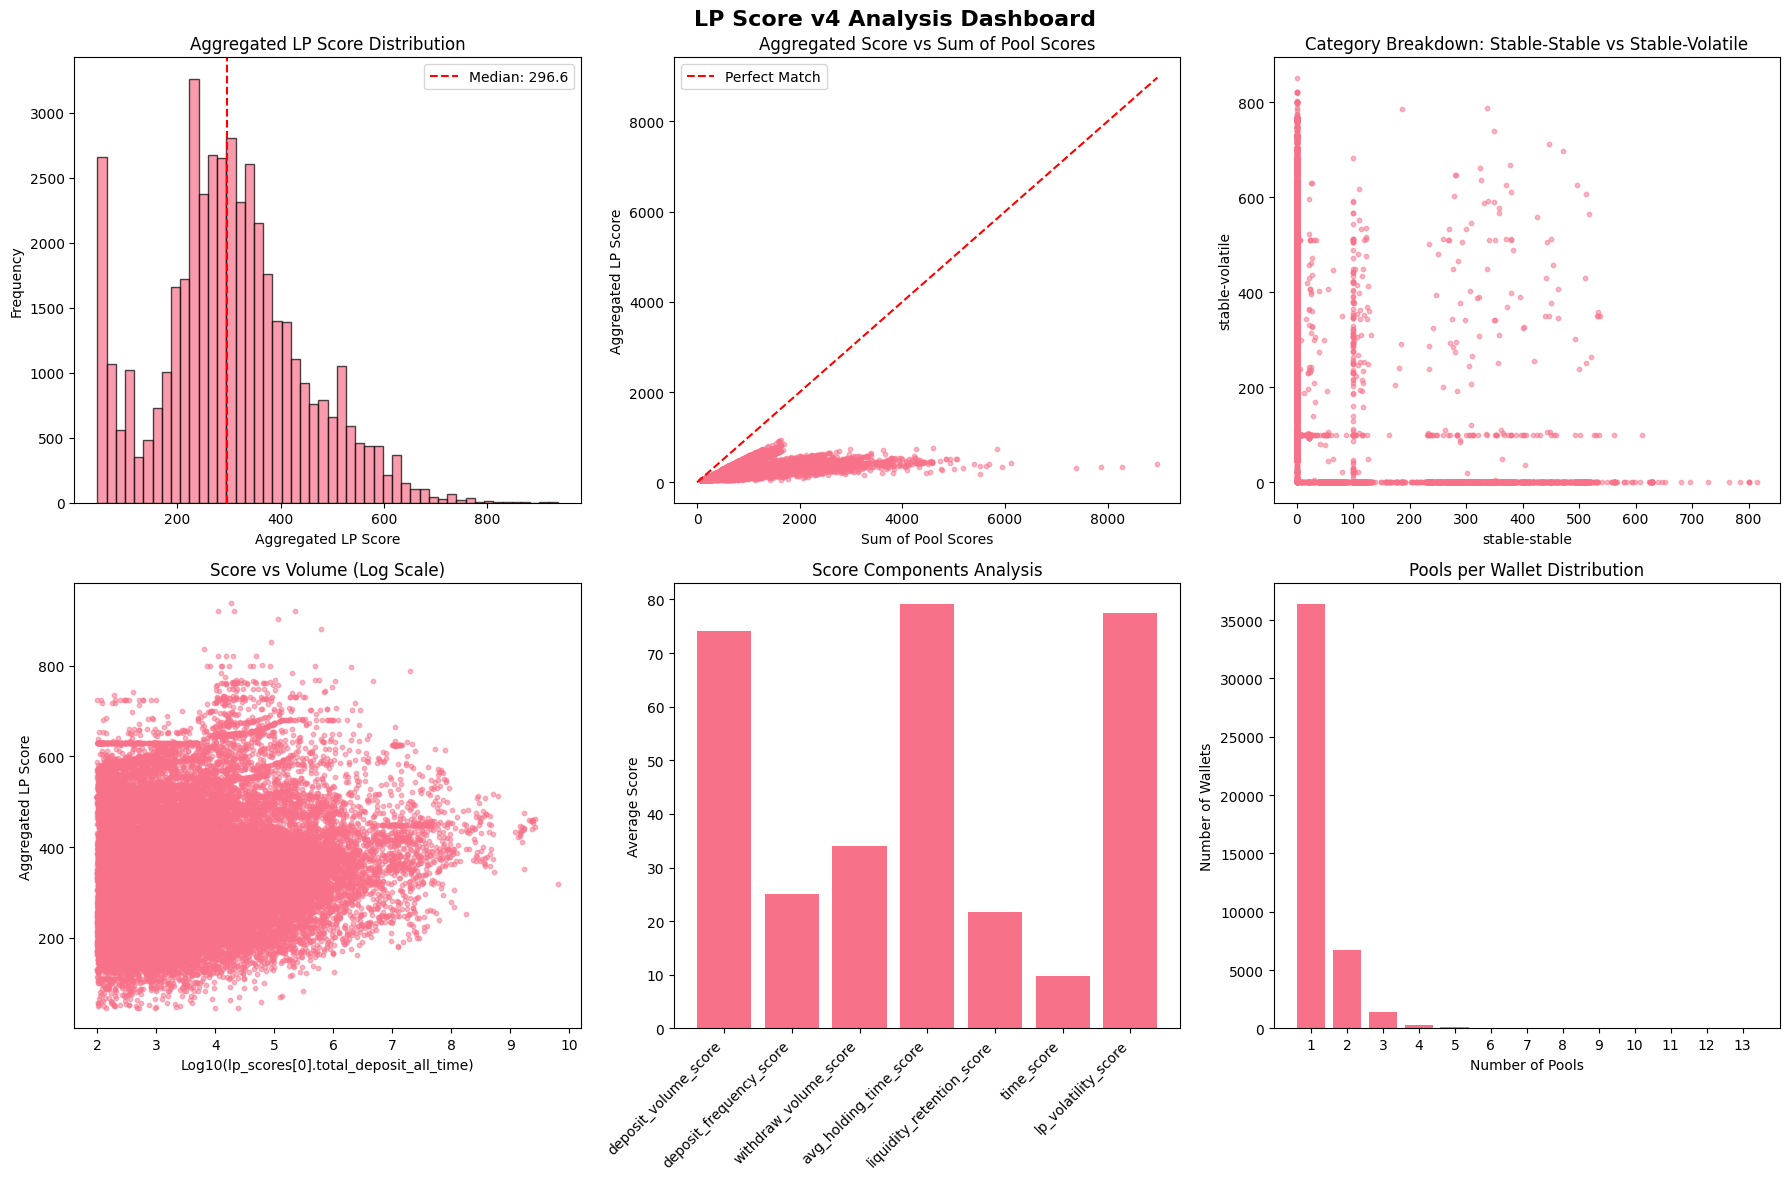

 Visualizations created successfully

 EXECUTIVE SUMMARY REPORT
 DATASET OVERVIEW:
• Total wallets: 44,975
• Total columns: 396
• Score range: 45.0 - 937.2
• Score median: 296.6
• Score 90th percentile: 14148.6

 KEY FINDINGS:
• Score construction: 0/44,975 exact matches (0.0%)
• Aggregated vs pool sum correlation: 0.6346
• Category breakdown matches: 18,355/44,975 (40.8%)
• Average volume-score correlation: 0.3423
• Component coherence: 100.0% average exact matches
• Total anomalies detected: 33,013
  - negative_value: 31,999
  - high_volume_low_score: 1,008
  - extreme_score_outlier: 6

 RECOMMENDATIONS:
• Category breakdown fields may not be simple score components
• Clarify relationship between categories and aggregated score
• High anomaly rate detected - review data quality processes
• Investigate extreme outliers and misaligned behavior-score pairs
 Exported 33013 anomalies to 'lp_score_anomalies.csv'

 ANALYSIS COMPLETED SUCCESSFULLY


In [20]:
results = run_complete_analysis('/content/dex-temp-db.score_v4.csv')